In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer 
import tensorflow as tf

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

In [4]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Bidirectional, Flatten
from keras.layers import Conv1D, MaxPooling1D,GlobalMaxPooling1D
from keras.layers import Add, Dense, Activation, Dropout
from keras.optimizers import Adam
from keras.metrics import Recall, Precision

In [5]:
dfn = pd.read_csv("all_tweets_1.csv")
dfn ['sentiment'].value_counts()

positive    2974
neutral     2262
negative     796
Name: sentiment, dtype: int64

In [6]:
pos = dfn.loc[dfn['sentiment'] == 'positive'].sample(n=796,random_state=42)
neg = dfn.loc[dfn['sentiment'] == 'negative']
neu = dfn.loc[dfn['sentiment'] == 'neutral'].sample(n=796,random_state=42)
df = pd.concat ([neg, neu, pos])

In [7]:
df['sentimentRU'] = df['sentiment']
df['sentimentRU'] = df['sentimentRU'].replace('positive', 'Позитивная')
df['sentimentRU'] = df['sentimentRU'].replace('negative', 'Негативная')
df['sentimentRU'] = df['sentimentRU'].replace('neutral', 'Нейтральная')

In [8]:
nltk.download('stopwords')
stopwords = stopwords.words('english')
lemmatize = nltk.WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Руслана\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def processingData (data):
    data = data.apply(lambda x: x.lower())
    data = data.apply(lambda x: re.sub("[^a-zA-Z]", " ", x)) 
    data = data.apply(lambda x: re.sub("\s+", " ", x))
    data = data.apply(lambda x: re.sub("rt", " ", x))
    data = data.apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
    data = data.apply(lambda x: ' '.join([lemmatize.lemmatize(word) for word in x.split()]))
    return data

In [10]:
df['text'] = processingData (df['text'])

In [11]:
Y = df["sentiment"]
X = df["text"]

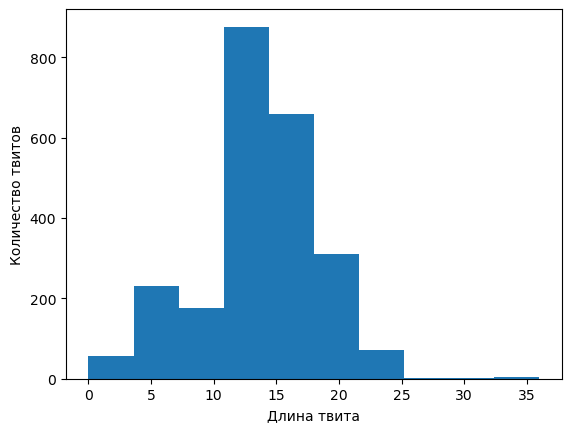

32546 words total, with a vocabulary size of 7678


In [12]:
tokenizerVocab = Tokenizer()
tokenizerVocab.fit_on_texts(X)
X_voc = tokenizerVocab.texts_to_sequences(X)
max_len = [len(tokens) for tokens in X_voc]
plt.hist(max_len,bins = 10)
plt.xlabel("Длина твита")
plt.ylabel("Количество твитов")
plt.show()
all_words = [word for tokens in X_voc for word in tokens] 
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, random_state = 42)

In [14]:
def get_metrics(y_test, y_predicted):
    precision = precision_score(y_test, y_predicted, pos_label=None, average='weighted')
    recall = recall_score(y_test, y_predicted, pos_label=None, average='weighted')
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

In [15]:
LinearSVC_TF = Pipeline([
    ('tfidvectorizer', TfidfVectorizer()),
    ('LinearSVC', LinearSVC())])

NB_TF = Pipeline([
    ('tfidvectorizer', TfidfVectorizer()),
    ('NB', MultinomialNB())])
 
LR_TF = Pipeline([
    ('tfidvectorizer', TfidfVectorizer()),
    ('LR', LogisticRegression(multi_class='multinomial'))
])


LinearSVC_TF.fit(x_train,y_train)
NB_TF.fit(x_train, y_train)
LR_TF.fit(x_train, y_train)

Pipeline(steps=[('tfidvectorizer', TfidfVectorizer()),
                ('LR', LogisticRegression(multi_class='multinomial'))])

In [16]:
LinearSVC_BoW = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('LinearSVC', LinearSVC())])

NB_BoW = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('NB', MultinomialNB())])

LR_BoW = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('LR', LogisticRegression( multi_class='multinomial'))
])

LinearSVC_BoW.fit(x_train,y_train)
NB_BoW.fit(x_train,y_train)
LR_BoW.fit(x_train,y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('LR', LogisticRegression(multi_class='multinomial'))])

In [17]:
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
Y = to_categorical(Y)

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 42)

In [19]:
max_len = 20
max_words = 3000
tokenizer = Tokenizer(max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq = tf.keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen = max_len)
test_X_seq = tokenizer.texts_to_sequences(X_test)
test_X_seq = tf.keras.preprocessing.sequence.pad_sequences(test_X_seq, maxlen = max_len)

In [20]:
model = Sequential()
model.add(Embedding(max_words, 10, input_length=max_len))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer= Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

In [21]:
history = model.fit(
    X_train_seq,
    Y_train,
    batch_size=128,
    epochs=20,
    verbose=1,
    validation_split= 0.2)

Epoch 1/20
12/12 [==============================] - 10s 197ms/step - loss: 1.0980 - accuracy: 0.3541 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0979 - val_accuracy: 0.3203 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
12/12 [==============================] - 0s 30ms/step - loss: 1.0934 - accuracy: 0.4372 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0915 - val_accuracy: 0.4429 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
12/12 [==============================] - 0s 27ms/step - loss: 1.0800 - accuracy: 0.5580 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.0651 - val_accuracy: 0.6574 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
12/12 [==============================] - 0s 27ms/step - loss: 1.0157 - accuracy: 0.7235 - precision: 1.0000 - recall: 0.0168 - val_loss: 0.9415 - val_accuracy: 0.6100 - val_precision: 0.8923 - val_recall: 0.1616
Epoch 5/20
12/12 [==============================] - 0s 25m

In [22]:
model1= Sequential()
model1.add(Embedding(max_words, 10, input_length=max_len))
model1.add(Conv1D(32, 3, activation='relu'))
model1.add(MaxPooling1D(2))
model1.add(Conv1D(32, 3, activation='relu'))
model1.add(Bidirectional(LSTM(32)))
model1.add(Dropout(0.2)) 
model1.add(Dense(3, activation='softmax'))
model1.compile(optimizer= Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

In [23]:
history = model1.fit(
    X_train_seq,
    Y_train,
    batch_size=128,
    epochs=20,
    verbose=1,
    validation_split= 0.2)

Epoch 1/20
12/12 [==============================] - 9s 187ms/step - loss: 1.0985 - accuracy: 0.3408 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 1.0983 - val_accuracy: 0.3955 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/20
12/12 [==============================] - 0s 22ms/step - loss: 1.0957 - accuracy: 0.3897 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 1.0942 - val_accuracy: 0.4095 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/20
12/12 [==============================] - 0s 21ms/step - loss: 1.0868 - accuracy: 0.5880 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 1.0746 - val_accuracy: 0.6407 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/20
12/12 [==============================] - 0s 23ms/step - loss: 1.0393 - accuracy: 0.5915 - precision_1: 1.0000 - recall_1: 0.0126 - val_loss: 0.9697 - val_accuracy: 0.5599 - val_precision_1: 1.0000 - val_recall_1: 0.1031
Epoch 5/20
12/12 [=========

In [24]:
model2 = Sequential()
model2.add(Embedding(max_words, 10, input_length=max_len))
model2.add(Conv1D(32,3,activation='relu'))
model2.add(MaxPooling1D(2))
model2.add(Conv1D(32,3,activation='relu'))
model2.add(GlobalMaxPooling1D())
model2.add(Dropout(0.2))
model2.add(Dense(3, activation='softmax'))
model2.compile(optimizer= Adam(0.001), loss='categorical_crossentropy',metrics=['accuracy', Precision(), Recall()])

In [25]:
history = model2.fit(
    X_train_seq,
    Y_train,
    batch_size=128,
    epochs=20,
    verbose=1,
    validation_split= 0.2)

Epoch 1/20
12/12 [==============================] - 2s 53ms/step - loss: 1.0962 - accuracy: 0.3715 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 1.0940 - val_accuracy: 0.3538 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/20
12/12 [==============================] - 0s 13ms/step - loss: 1.0856 - accuracy: 0.4490 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 1.0855 - val_accuracy: 0.4039 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/20
12/12 [==============================] - 0s 12ms/step - loss: 1.0738 - accuracy: 0.4707 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 1.0744 - val_accuracy: 0.3900 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 4/20
12/12 [==============================] - 0s 14ms/step - loss: 1.0535 - accuracy: 0.4951 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 1.0510 - val_accuracy: 0.4875 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 5/20
1

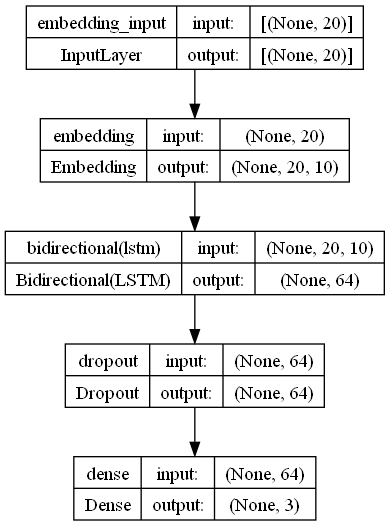

In [26]:
tf.keras.utils.plot_model(model, show_shapes=True)

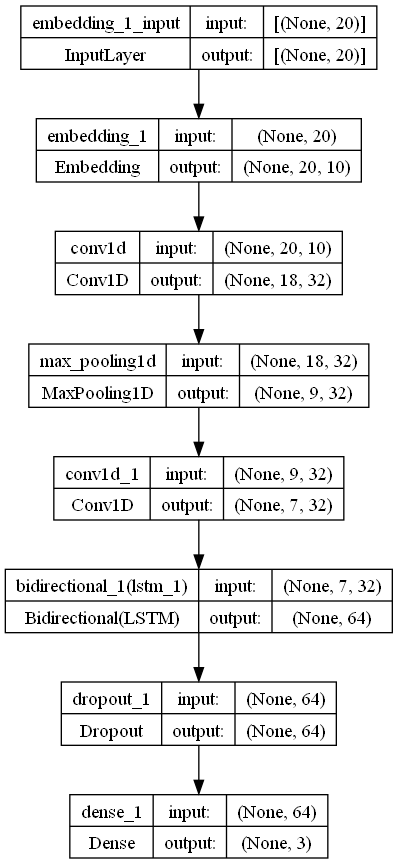

In [27]:
tf.keras.utils.plot_model(model1, show_shapes=True)

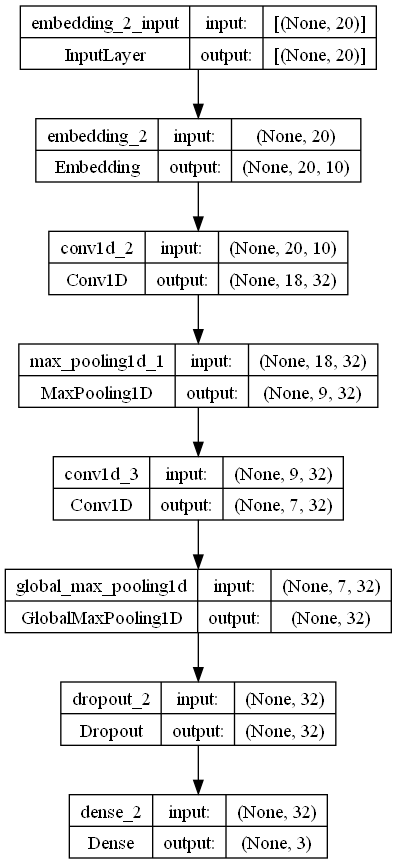

In [28]:
tf.keras.utils.plot_model(model2, show_shapes=True)

In [29]:
results1 = model.evaluate(test_X_seq, Y_test) #LSTM
results2 = model1.evaluate(test_X_seq, Y_test) # LSTM CNN
results3 = model2.evaluate(test_X_seq, Y_test) #CNN

19/19 [==============================] - 0s 5ms/step - loss: 0.5038 - accuracy: 0.8476 - precision_2: 0.8532 - recall_2: 0.8375


In [31]:
predicted_svc_bow = LinearSVC_BoW.predict(x_test)
predicted_nb_bow = NB_BoW.predict(x_test)
predicted_lr_bow = LR_BoW.predict(x_test)
predicted_svc_tf = LinearSVC_TF.predict(x_test)
predicted_nb_tf = NB_TF.predict(x_test)
predicted_lr_tf = LR_TF.predict(x_test)

print ("Metrics SVC + TF-IDF: accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % get_metrics(y_test, predicted_svc_tf))
print ("Metrics NB + TF-IDF: accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % get_metrics(y_test,predicted_nb_tf))
print ("Metrics LR + TF-IDF: accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % get_metrics(y_test,predicted_lr_tf))
print ("Metrics SVC + Bag-of-Words: accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % get_metrics(y_test,predicted_svc_bow))
print ("Metrics NB + Bag-of-Words: accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % get_metrics(y_test,predicted_nb_bow))
print ("Metrics LR + Bag-of-Words: accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % get_metrics(y_test,predicted_lr_bow))

Metrics SVC + TF-IDF: accuracy = 0.858, precision = 0.858, recall = 0.858, f1 = 0.858
Metrics NB + TF-IDF: accuracy = 0.831, precision = 0.835, recall = 0.831, f1 = 0.831
Metrics LR + TF-IDF: accuracy = 0.854, precision = 0.855, recall = 0.854, f1 = 0.854
Metrics SVC + Bag-of-Words: accuracy = 0.868, precision = 0.871, recall = 0.868, f1 = 0.868
Metrics NB + Bag-of-Words: accuracy = 0.827, precision = 0.833, recall = 0.827, f1 = 0.828
Metrics LR + Bag-of-Words: accuracy = 0.861, precision = 0.867, recall = 0.861, f1 = 0.861


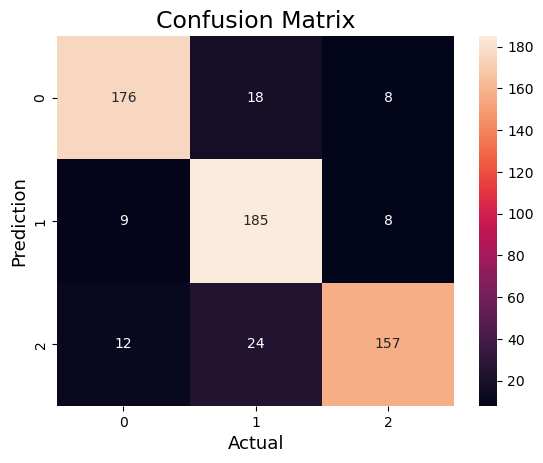

In [32]:
cm_SVC_BoW = confusion_matrix(y_test, predicted_svc_bow)
sns.heatmap(cm_SVC_BoW,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()